In [43]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz

from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, roc_curve
from sklearn.metrics import accuracy_score

data = pd.read_csv('Bacteria_Gene_Quantified.csv')
gene_data = data.drop('Bacteria',axis=1)
# Toxin-antitoxin gene corresponds to a gene that creates a toxin and an antitoxin
gene_data["Toxin"] = gene_data["Toxin"] + gene_data["Toxin-antitoxin"]
gene_data["Antitoxin"] = gene_data["Antitoxin"] + gene_data["Toxin-antitoxin"]


#To verify if a category is made up of mostly core genes coefficient of variation is used
std_all = gene_data.std()
var_coefficient = gene_data.std() / gene_data.mean()
core_genes = var_coefficient < 0.08

#Force Toxin-antitoxin removal
core_genes["Toxin-antitoxin"] = True

bacteria = gene_data.loc[:, ~core_genes]

data2 = pd.read_csv('Phages.csv')
data2.head()

gene_data = bacteria.iloc[:,2:]
gene_data["Number of Phages"] = data2["fagos"]
print(gene_data)

    Drug  Repressor  Antitoxin  Toxin  Adhesin  Hemolysin   Flagellar  \
0     32         35         18     20        3           2         30   
1     40         39         12     25        7           4         30   
2     41         39         15     20        5           8         30   
3     32         32         11     14        4           3         17   
4     31         33         18     20        2           2         30   
5     39         41         10     19        5           1         30   
6     34         36         17     19        3           5         30   
7     31         35         14     14        4           3         30   
8     38         37         12     15        7           2         31   
9     31         39         14     12        4           3         30   
10    32         33         15     17        4           3         46   
11    37         32         11     14        4           2         30   
12    32         36         13     13        4     

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


y = gene_data['Number of Phages']
X = gene_data.drop(['Number of Phages'],axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 23)

regressor = GradientBoostingRegressor(random_state = 3)

param_grid = {
    'n_estimators' : [50, 100, 150, 200],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
    'max_depth' : [1, 2, 3, 4, 5],
    'max_features' : [1, 5, 10, 15, 20]
}

grid_search = GridSearchCV(estimator = regressor, param_grid = param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 1, 'n_estimators': 50}
Best Score: -1.9408496406329323


In [67]:
model = GradientBoostingRegressor(n_estimators = 50,learning_rate = 0.05, max_depth=5,max_features = 1, random_state=3)
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features=1,
                          n_estimators=50, random_state=3)

In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print('Mean Squared Error = ' + str(mse))
r2 = r2_score(y_test, y_pred)

print(f"R-squared (R²): {r2}")

Mean Squared Error = 13.696143958547907
R-squared (R²): 0.18762445472931788


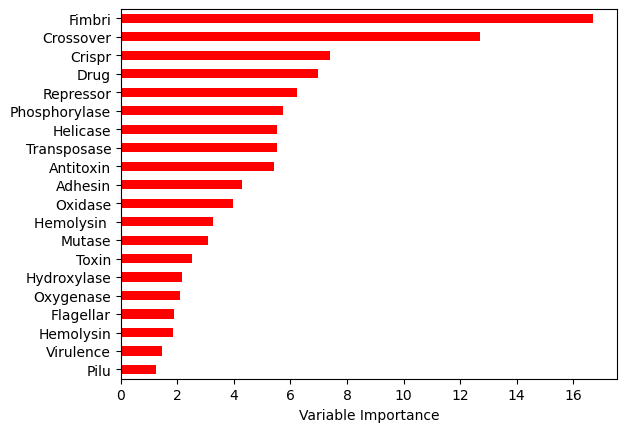

In [71]:
feature_importance = model.feature_importances_*100

rel_imp = pd.Series(feature_importance, index = X.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None
plt.show()